In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
import ast

#loading the dataset (originally from https://www.kaggle.com/datasets/fronkongames/steam-games-dataset; had to manually add a comma to separate Discount and DLC)
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/CP322/regression.csv" # save to github: notebooks/workingFile.ipynb
steam = pd.read_csv(path, index_col=False, on_bad_lines='skip', engine='python')
steam.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Peak CCU,Price,Discount,DLC count,Windows,Mac,Linux,Metacritic score,User score,Achievements,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_available
0,2164,59.99,0,5,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,7571,59.99,0,15,1,0,0,0,0,178,...,0,0,0,0,0,0,0,0,0,0
2,49,3.49,0,0,1,0,0,89,0,0,...,0,0,0,0,0,0,0,0,0,0
3,133,2.99,0,1,1,1,1,0,0,35,...,0,0,0,0,0,0,0,0,0,0
4,358,23.99,0,11,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


identify y



Distribution of Average playtime two weeks:
count     2739.000000
mean       369.035049
std        923.907960
min          1.000000
25%         27.000000
50%        104.000000
75%        378.000000
max      10996.000000
Name: Average playtime two weeks, dtype: float64


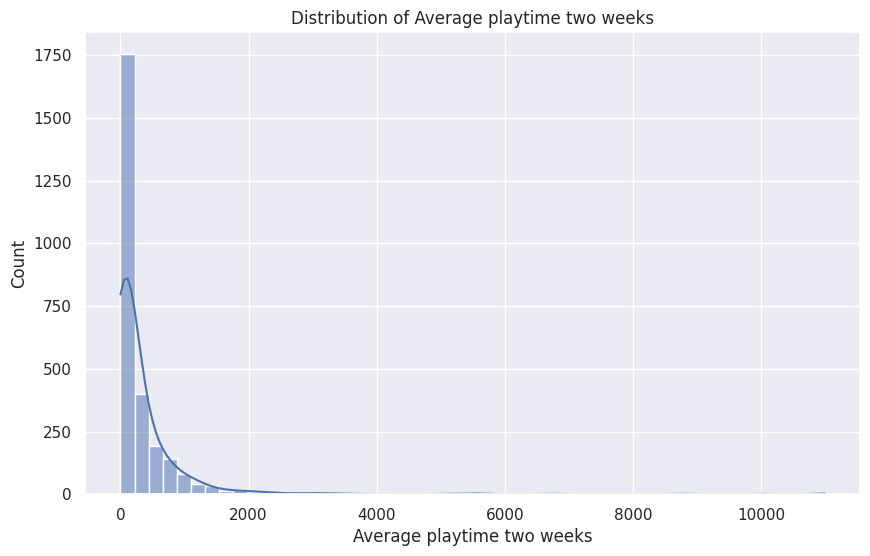

In [2]:

target_column = 'Average playtime two weeks'
print(f"\nDistribution of {target_column}:")
print(steam[target_column].describe())
plt.figure(figsize=(10, 6))
sns.histplot(steam[target_column], bins=50, kde=True)
plt.title(f'Distribution of {target_column}')
plt.xlabel(target_column)
plt.ylabel('Count')
plt.show()

Apply XGBoost and identify important columns

shape of training data: X_train=(2191, 121), y_train=(2191,)
shape of testing data: X_test=(548, 121), y_test=(548,)

xgboost model performance
rmse 1010.90
r-squared: -0.11
mae: 415.57

important features:
Action                   0.059185
fantasy_violence         0.050574
mild_fantasy_violence    0.038603
mild_violence            0.037897
esrb_available           0.036927
Indie                    0.035107
Captions available       0.034935
Racing                   0.032376
no_descriptors           0.032318
Remote Play on TV        0.030427
dtype: float32


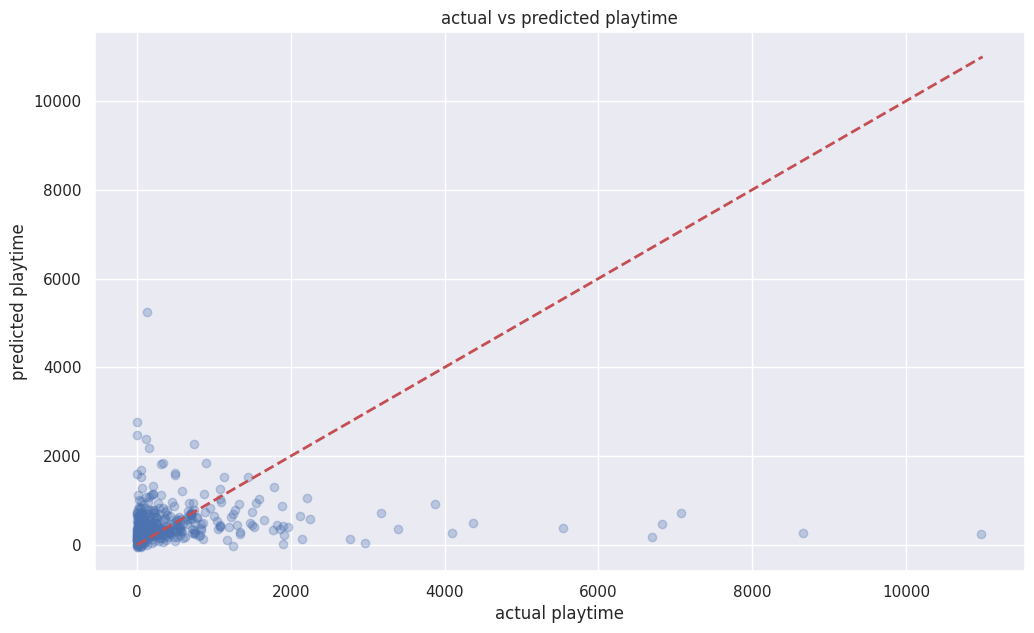

In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#drop the target column from features
x = steam.drop(columns=target_column, errors='ignore')
y = steam[target_column]


#handle any remaining non-numeric columns that slipped through convert to numeric if possible, otherwise drop
for col in x.columns:
    if x[col].dtype == 'object':
        try:
            x[col] = pd.to_numeric(x[col], errors='coerce')
        except:            x = x.drop(columns=[col])

#drop rows with NaN values
initial_rows = x.shape[0]
combined = pd.concat([x, y], axis=1).dropna(subset=[target_column])
x = combined.drop(columns=[target_column])
y = combined[target_column]

if initial_rows > x.shape[0]:
    print(f"dropped {initial_rows - x.shape[0]} rows due to NaN in target variable.\n")
x = x.fillna(x.mean())

#split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"shape of training data: X_train={x_train.shape}, y_train={y_train.shape}")
print(f"shape of testing data: X_test={x_test.shape}, y_test={y_test.shape}\n")

# Initialize and train the XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"xgboost model performance")
print(f"rmse {rmse:.2f}")
print(f"r-squared: {r2:.2f}")
print(f"mae: {mae:.2f}\n")

#identify important features
print("important features:")
feature_importances = pd.Series(xgb_model.feature_importances_, index=x.columns)
print(feature_importances.nlargest(10))

#plot
plt.figure(figsize=(12, 7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("actual playtime")
plt.ylabel("predicted playtime")
plt.title("actual vs predicted playtime")
plt.show()

In [4]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

In [5]:
from sklearn.model_selection import GridSearchCV

#xgb regressor
xgb = XGBRegressor(random_state=42, n_jobs=-1)

#grid search
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

In [6]:
#fit grid search
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.7, 0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [7]:
print("best parameters:", grid_search.best_params_)
print("best rmse:", np.sqrt(-grid_search.best_score_))

best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
best rmse: 898.1601042779994


xgb performance
rmse: 944.52
r-squared: 0.03
mae: 404.14


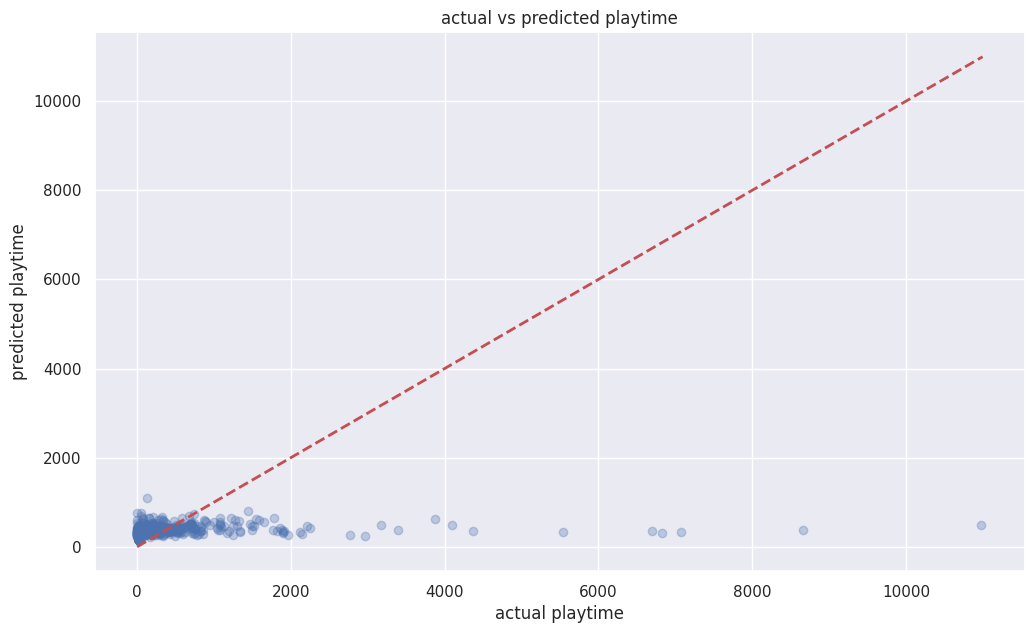

In [8]:
best_xgb_model = grid_search.best_estimator_

#make prediction
y_pred_tuned = best_xgb_model.predict(x_test)

#evaluate model
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"xgb performance")
print(f"rmse: {rmse_tuned:.2f}")
print(f"r-squared: {r2_tuned:.2f}")
print(f"mae: {mae_tuned:.2f}")

#plot predictions vs actual for tuned model
plt.figure(figsize=(12, 7))
plt.scatter(y_test, y_pred_tuned, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("actual playtime")
plt.ylabel("predicted playtime")
plt.title("actual vs predicted playtime")
plt.show()